In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
from dython.nominal import associations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
     

# Carga y Exploración de Datos


In [2]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

def feature_summary(data, feature_type, features, num_unique = None):
    """
    Imprime un resumen de las características.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos que contiene las características.
    feature_type : str
        Tipo de características (e.g., 'numéricas', 'categóricas').
    features : list
        Lista de nombres de columnas que se desean resumir.
    num_unique : int, opcional
        Número de valores únicos a mostrar. Si es None, se mostrarán todos los valores únicos.
    """
    print(f'\n{feature_type}\n{data[features].describe().T.to_string()}')
    print(f'\nLa cantidad de features {feature_type} son: {len(features)} y son: {", ".join(features.tolist())}')
    
    for var in features.tolist():
        if num_unique:
            print(f'Los valores unicos de {var} son: {", ".join(map(str, data[var].unique()[:num_unique]))} (mostrando los primeros {num_unique})')
        else:
            print(f'Los valores unicos de {var} son: {", ".join(map(str, data[var].unique()))}')

def calculate_skew_kurtosis(data, features):
    """
    Calcula la asimetría y la curtosis para cada variable numérica en un DataFrame,
    y clasifica las variables según estos valores.

    Parámetros:
    ----------
    data : pandas.DataFrame
        DataFrame que contiene las variables numéricas para las cuales se calcularán
        las medidas de asimetría y curtosis.

    Retorna:
    -------
    pd.DataFrame : DataFrame con las columnas 'Variable', 'Asimetría', 'Curtósis' y 'Clasificación',
    mostrando el valor de asimetría, curtosis y su respectiva clasificación para cada variable.
    """

    kur_skw = pd.DataFrame()

    for i in features:
        kur = kurtosis(data[i], axis=0, bias=True)
        if kur > 0:
            clas1 = 'Leptocúrtica'
        elif kur == 0:
            clas1 = 'Mesocúrtica'
        else:
            clas1 = 'Platicúrtica'

        skw = skew(data[i], axis=0, bias=True)
        if -0.5 <= skw <= 0.5:
            clas2 = 'Simétrica'
        elif skw < -0.5:
            clas2 = 'Sesgo negativo'
        else:
            clas2 = 'Sesgo positivo'

        # Crear un nuevo DataFrame con los resultados y concatenarlo
        new_row = pd.DataFrame([[i, skw, kur, clas2 + ' y ' + clas1]],
                               columns=['Variable', 'Asimetría', 'Curtósis', 'Clasificación'])
        kur_skw = pd.concat([new_row, kur_skw], ignore_index=True)

    return kur_skw


def print_feature_summary(data):
    """Imprime un resumen de las características numéricas y categóricas."""
    num_features = data.select_dtypes(include=['float', 'int']).columns
    cat_features = data.select_dtypes(include=['object']).columns
    
    print('\nClasificación de features por tipo')
    feature_summary(data,'Numéricas', num_features, num_unique = 5)
    print('\nMedidas de asimetría y curtósis, clasificación')
    print(calculate_skew_kurtosis(data, num_features))
    feature_summary(data,'Categóricas', cat_features)

def explore_data(data):  
    """
    Realiza un análisis exploratorio del DataFrame proporcionado.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos a explorar.
    """
    print(data.head().T)
    print(data.info())
    print('\nCantidad de valores nulos por feature\n\n'+ data.isnull().sum().to_string())
    print_feature_summary(data)

    

# Visualizar Datos

In [3]:
def plot_histograms(data,num_features):
    num_features = data.select_dtypes(include=['float', 'int']).columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    plt.suptitle("KDE + Histograma", fontsize=16)
    axs = axs.ravel()

    for col, ax in zip(data[num_features], axs):
        sns.histplot(x=data[col].dropna(), bins=20, kde=True, ax=ax)
        ax.axvline(data[col].mean(), color='red', linestyle='dashed', label=f'Media: {data[col].mean():.2f}')
        ax.axvline(data[col].median(), color='green', linestyle='dashed', label=f'Mediana: {data[col].median():.2f}')
        ax.axvline(data[col].mode().iloc[0], color='black', linestyle='dashed', label=f'Moda: {data[col].mode().iloc[0]:.2f}')
        ax.set(title=col, xlabel='Valores', ylabel='Frecuencia')
        ax.legend()

    # Ajusta el espacio entre los subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()

def plot_outliers(data,num_features):
    
    fig, axs = plt.subplots(1, 3, figsize=(8, 5))
    plt.suptitle("Valores Atípicos", fontsize=16)
    axs.ravel()

    for col, ax in zip(data[num_features],axs):
        sns.boxplot(y = col, data = data, ax = ax)
        ax.set(title = col, xlabel = None, ylabel = 'Valores')
    
    # Ajusta el espacio entre los subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()


def display_correlation_matrix(data):
    plt.figure(figsize=(6, 5))
    plt.title('Matriz de Correlación')
    sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f")
    plt.show()


def display_numerical_analysis(data):
    num_features = data.select_dtypes(include=['float', 'int']).columns
    plot_histograms(data, num_features)
    plot_outliers(data, num_features)
    display_correlation_matrix(data)


def plot_category_counts(data,cat_features):
    fig, axs = plt.subplots(7, 2, figsize=(14, 16))
    plt.suptitle("Distribución de features categóricas", fontsize=16)
    axs = axs.ravel()

    for col, ax in zip(data[cat_features], axs):
        sns.countplot(y=col, hue=col, data=data, palette='pastel', legend=False, ax=ax)

        for p in ax.patches:
            ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='center', va='center', fontsize=8, color='black', xytext=(4, 0),
                        textcoords='offset points')

        # Ajustamos los labels y el título.
        ax.set(title=col, xlabel='Cantidad', ylabel=None)

    # Ajusta el espacio entre los subplots
    plt.tight_layout()

    # Muestra los subplots
    plt.show()

def plot_categorical_target_analysis(data,cat_features,target):
    new_cat_features = cat_features[~cat_features.isin(['NObeyesdad'])]
    fig, axs = plt.subplots(7, 2, figsize=(14, 30),constrained_layout=True)
    plt.suptitle("Distribución de features categóricas respecto a NObeyesdad", fontsize=16,)
    axs = axs.ravel()

    for col, ax in zip(data[new_cat_features], axs):

        sns.countplot(y=target, hue=col, data=data, palette='pastel', legend=True, ax=ax)

        for p in ax.patches:
            ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='center', va='center', fontsize=8, color='black', xytext=(4, 0),
                        textcoords='offset points')

            # Ajustamos los labels y el título.
            ax.set(title=col, xlabel='Cantidad', ylabel=None)

    # Ajusta el espacio entre los subplots
    #plt.subplots_adjust(top=0.95)  # Ajustar el valor top para dar más espacio
    for j in range(len(new_cat_features), len(axs)):
        axs[j].axis('off')
    #plt.tight_layout(rect=[0, 0, 1, 0.99])
    # Muestra los subplots
    plt.show()


def plot_association_matrix(data,cat_features):
    associations(data[cat_features], plot=True, figsize=(10, 10), title='Matriz de Correlación de Variables Categóricas')


def display_categorical_analysis(data):
    cat_features = data.select_dtypes(include = ['object']).columns
    plot_category_counts(data, cat_features)
    plot_categorical_target_analysis(data,cat_features,'NObeyesdad')
    plot_association_matrix(data,cat_features)


# Ajuste de tipos de Datos

In [4]:
def convert_int_to_str(data, int_to_str):
    """
    Convierte las columnas especificadas de enteros a cadenas de texto.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos que contiene las columnas a convertir.
    int_to_str : list or str
        Lista o nombre de las columnas que deben ser convertidas de enteros a cadenas de texto.

    Retorna:
    -------
    data : pandas.DataFrame
        Conjunto de datos con las columnas especificadas convertidas a cadenas de texto.

    Notas:
    -----
    - Si `int_to_str` es una lista o un nombre de columna válido, convierte las columnas especificadas al tipo `str`.
    - Si `int_to_str` es `None` o vacío, la función no realiza ninguna conversión y retorna el DataFrame original.
    """
    if int_to_str:
        data[int_to_str] = data[int_to_str].astype(str)
    return data


def convert_float_to_int(data, float_to_int):
    """
    Convierte las columnas especificadas de flotantes a enteros.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos que contiene las columnas a convertir.
    float_to_int : list or str
        Lista o nombre de las columnas que deben ser convertidas de flotantes a enteros.

    Retorna:
    -------
    data : pandas.DataFrame
        Conjunto de datos con las columnas especificadas convertidas a enteros.

    Notas:
    -----
    - Si `float_to_int` es una lista o un nombre de columna válido, convierte las columnas especificadas al tipo `int`.
    - Si `float_to_int` es `None` o vacío, la función no realiza ninguna conversión y retorna el DataFrame original.
    """
    if float_to_int:
        data[float_to_int] = data[float_to_int].astype(int)
    return data


def round_columns(data, round_decimals):
    """
    Redondea las columnas especificadas del DataFrame a un número específico de decimales.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos que contiene las columnas a redondear.
    round_decimals : int, dict, or tuple
        - Si es un entero, redondea todas las columnas numéricas a ese número de decimales.
        - Si es un diccionario, redondea columnas específicas con diferentes precisiones. 
          Las claves son los nombres de las columnas y los valores son los decimales.
        - Si es una tupla, el primer elemento es la lista de columnas a redondear y el segundo es el número de decimales.

    Retorna:
    -------
    data : pandas.DataFrame
        Conjunto de datos con las columnas redondeadas al número de decimales especificado.

    Notas:
    -----
    - Si `round_decimals` es un entero, redondea todas las columnas numéricas del DataFrame.
    - Si es un diccionario, permite especificar un número diferente de decimales por cada columna.
    - Si es una tupla, permite redondear un subconjunto de columnas a un número de decimales específico.
    - Si `round_decimals` es `None`, la función no realiza ninguna operación y retorna el DataFrame original.
    """
    if round_decimals is not None:
        if isinstance(round_decimals, int):
            data = data.round(round_decimals)
        elif isinstance(round_decimals, dict):
            for col, decimals in round_decimals.items():
                data[col] = data[col].round(decimals)
        elif isinstance(round_decimals, tuple):
            columns, decimals = round_decimals
            data[columns] = data[columns].round(decimals)
    return data


def adjust_data_types(data, int_to_str=None, float_to_int=None, round_decimals=None):
    """
    Ajusta los tipos de datos del DataFrame mediante la conversión de tipos y el redondeo de columnas.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos que se va a ajustar.
    int_to_str : list or str, opcional
        Lista o nombre de las columnas que deben ser convertidas de enteros a cadenas de texto.
    float_to_int : list or str, opcional
        Lista o nombre de las columnas que deben ser convertidas de flotantes a enteros.
    round_decimals : int, dict, or tuple, opcional
        - Si es un entero, redondea todas las columnas numéricas a ese número de decimales.
        - Si es un diccionario, redondea columnas específicas con diferentes precisiones.
        - Si es una tupla, el primer elemento es una lista de columnas a redondear y el segundo es el número de decimales.

    Retorna:
    -------
    data_adjusted : pandas.DataFrame
        Conjunto de datos con los ajustes en los tipos de datos y redondeo aplicados.

    Notas:
    -----
    - Llama a las funciones `round_columns`, `convert_float_to_int` y `convert_int_to_str` para aplicar los ajustes especificados.
    - Si no se proporcionan parámetros opcionales, el DataFrame se retorna sin cambios.
    """
    data_adjusted = data.copy()
    data_adjusted = round_columns(data_adjusted, round_decimals)
    data_adjusted = convert_float_to_int(data_adjusted, float_to_int)
    data_adjusted = convert_int_to_str(data_adjusted, int_to_str)
    return data_adjusted

# División de los datos en conjuntos de entrenamiento, validación y prueba


In [5]:
def split_data(data, target, test_size=0.2, val_size=0.1, random_state=1):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos que contiene las características y la variable objetivo.
    target : str
        Nombre de la columna que contiene la variable objetivo.
    test_size : float, opcional (default=0.2)
        Proporción de los datos que se asignarán al conjunto de prueba.
    val_size : float, opcional (default=0.1)
        Proporción de los datos de entrenamiento que se asignarán al conjunto de validación.
    random_state : int, opcional (default=1)
        Semilla aleatoria para asegurar la reproducibilidad de la división de los conjuntos.

    Retorna:
    -------
    tuple : (X_train, X_test, X_val, y_train, y_test, y_val)
        - X_train : pandas.DataFrame
            Conjunto de entrenamiento de características.
        - X_test : pandas.DataFrame
            Conjunto de prueba de características.
        - X_val : pandas.DataFrame
            Conjunto de validación de características.
        - y_train : pandas.Series
            Valores objetivo correspondientes al conjunto de entrenamiento.
        - y_test : pandas.Series
            Valores objetivo correspondientes al conjunto de prueba.
        - y_val : pandas.Series
            Valores objetivo correspondientes al conjunto de validación.

    Notas:
    -----
    - La función primero divide el conjunto de datos original en entrenamiento y prueba de acuerdo con el parámetro `test_size`.
    - Luego, divide el conjunto de entrenamiento resultante en entrenamiento y validación de acuerdo con el parámetro `val_size`.
    """
    X = data.drop(target, axis=1)
    y = data[target]

    # División en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # División en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=random_state, test_size=val_size)

    return X_train, X_test, X_val, y_train, y_test, y_val

# Preprocesamiento e ingeniería de características

In [6]:
def select_features(data, target):
    """
    Selecciona y clasifica las características del conjunto de datos en numéricas, categóricas y ordinales.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos completo que incluye las características y la variable objetivo.
    target : str
        Nombre de la columna que contiene la variable objetivo.

    Retorna:
    -------
    tuple : (numerical_features, categorical_features, ordinal_features)
        - numerical_features : pandas.Index
            Características numéricas (excluyendo 'Age').
        - categorical_features : pandas.Index
            Características categóricas que no son ordinales.
        - ordinal_features : pandas.Index
            Características categóricas ordinales predefinidas ('FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'CALC').
    """
    num_features = data.select_dtypes(include=['int', 'float']).columns
    cat_features = data.select_dtypes(include=['object', 'category']).columns.drop(target)
    ordinal_features = cat_features[cat_features.isin(['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'CALC'])]
    categorical_features = cat_features[~cat_features.isin(ordinal_features)]
    numerical_features = num_features[~num_features.isin(['Age'])]
    
    return numerical_features, categorical_features, ordinal_features

In [7]:
def create_pipelines(numerical_features, categorical_features, ordinal_features):
    """
    Crea pipelines para preprocesar características numéricas, categóricas y ordinales.

    Parámetros:
    ----------
    numerical_features : pandas.Index
        Columnas del conjunto de datos que contienen características numéricas.
    categorical_features : pandas.Index
        Columnas del conjunto de datos que contienen características categóricas no ordinales.
    ordinal_features : pandas.Index
        Columnas del conjunto de datos que contienen características categóricas ordinales.

    Retorna:
    -------
    preprocessing_pipeline : sklearn.compose.ColumnTransformer
        Un transformador compuesto que aplica diferentes pipelines a las características numéricas, categóricas y ordinales.
    """
    log_pipeline = Pipeline(steps = [
        ('log_transform', FunctionTransformer(func=np.log, validate=False)),
        ('Scaler', StandardScaler())
    ])

    num_pipeline = Pipeline(steps = [
        ('Scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('binary', BinaryEncoder(handle_unknown='ignore'))
    ])

    ord_pipeline = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())
    ])

    preprocessing_pipeline = ColumnTransformer(transformers=[
        ('log', log_pipeline, ['Age']),
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
        ('ord', ord_pipeline, ordinal_features)
    ])

    return preprocessing_pipeline

In [8]:
def preprocess_data(data, target, test_size=0.2, val_size=0.1, random_state=1):
    """
    Preprocesa los datos dividiéndolos en conjuntos de entrenamiento, validación y prueba,
    y aplica una serie de transformaciones a las características numéricas, categóricas y ordinales.

    Los datos preprocesados se retornan como DataFrames con las respectivas características originales.

    Parámetros:
    ----------
    data : pandas.DataFrame
        Conjunto de datos completo que incluye las características y la variable objetivo.
    target : str
        Nombre de la columna que contiene la variable objetivo.
    test_size : float, opcional (default=0.2)
        Proporción de datos que se asignarán al conjunto de prueba.
    val_size : float, opcional (default=0.1)
        Proporción de datos que se asignarán al conjunto de validación, respecto al conjunto total.
    random_state : int, opcional (default=1)
        Valor de la semilla aleatoria para asegurar la reproducibilidad de los conjuntos de datos.

    Retorna:
    -------
    tuple : (X_train_preprocessed, X_test_preprocessed, X_val_preprocessed, y_train, y_test, y_val)
        - X_train_preprocessed : pandas.DataFrame
            Conjunto de entrenamiento después del preprocesamiento con características originales.
        - X_val_preprocessed : pandas.DataFrame
            Conjunto de validación después del preprocesamiento con características originales.
        - X_test_preprocessed : pandas.DataFrame
            Conjunto de prueba después del preprocesamiento con características originales.
        - y_train : pandas.Series
            Valores objetivo correspondientes al conjunto de entrenamiento.
        - y_val : pandas.Series
            Valores objetivo correspondientes al conjunto de validación.
        - y_test : pandas.Series
            Valores objetivo correspondientes al conjunto de prueba.
        - preprocessing_pipeline : ColumnTransformer
            El pipeline de preprocesamiento utilizado.
    """
    numerical_features, categorical_features, ordinal_features = select_features(data, target)
    
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(data, target, test_size, val_size, random_state)

    # Crear el pipeline de preprocesamiento
    preprocessing_pipeline = create_pipelines(numerical_features, categorical_features, ordinal_features)

    # Ajustar el pipeline al conjunto de entrenamiento
    X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
    X_val_preprocessed = preprocessing_pipeline.transform(X_val)
    X_test_preprocessed = preprocessing_pipeline.transform(X_test)

    # Obtener los nombres de las columnas transformadas
    num_feature_names = numerical_features
    cat_feature_names = preprocessing_pipeline.named_transformers_['cat']['binary'].get_feature_names_out(categorical_features)
    ord_feature_names = ordinal_features

    # Combinar los nombres de las características
    feature_names = ['Age'] + list(num_feature_names) + list(cat_feature_names) + list(ord_feature_names)

    # Convertir los resultados preprocesados a DataFrames
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
    X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names, index=X_test.index)

    return X_train_preprocessed, X_test_preprocessed, X_val_preprocessed, y_train, y_test, y_val


# Entrenar el modelo

In [9]:
def train_model(X_train, y_train):
    model = GradientBoostingClassifier(learning_rate=0.1, 
                                       max_depth=3, 
                                       n_estimators=100)
    model.fit(X_train, y_train)
    return model

# Evaluar el modelo

In [10]:
def evaluate_model(model, X_test, y_test, set_type = 'Prueba'):
    y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores reales')
    plt.title(f'Matriz de Confusión del set de {set_type}') 
    plt.show()

    print(f"Classification Report del set de {set_type}:")
    print(classification_report(y_test, y_pred))


# Función Principal

In [11]:
def main(filepath):
    data = load_data(filepath)
    data_adjusted = adjust_data_types(data,
                                      round_decimals ={'Height' : 2, 'Weight' : 0, 'CH2O' : 0},  
                                      float_to_int = ['Weight', 'Age', 'FCVC', 'NCP', 'FAF', 'TUE', 'CH2O'],
                                      int_to_str = ['FCVC', 'NCP', 'FAF', 'TUE', 'CH2O']
                                      )
    explore_data(data_adjusted)
    display_numerical_analysis(data_adjusted)
    display_categorical_analysis(data_adjusted)
    X_train_pre, X_test_pre, X_val_pre, y_train, y_test, y_val = preprocess_data(data_adjusted, 'NObeyesdad')
    model = train_model(X_train_pre,y_train)
    evaluate_model(model,
                   X_test = X_test_pre,
                   y_test= y_test,
                   set_type = 'Prueba')

                                                    0                      1  \
Gender                                         Female                 Female   
Age                                                21                     21   
Height                                           1.62                   1.52   
Weight                                             64                     56   
family_history_with_overweight                    yes                    yes   
FAVC                                               no                     no   
FCVC                                                2                      3   
NCP                                                 3                      3   
CAEC                                        Sometimes              Sometimes   
SMOKE                                              no                    yes   
CH2O                                                2                      3   
SCC                                     

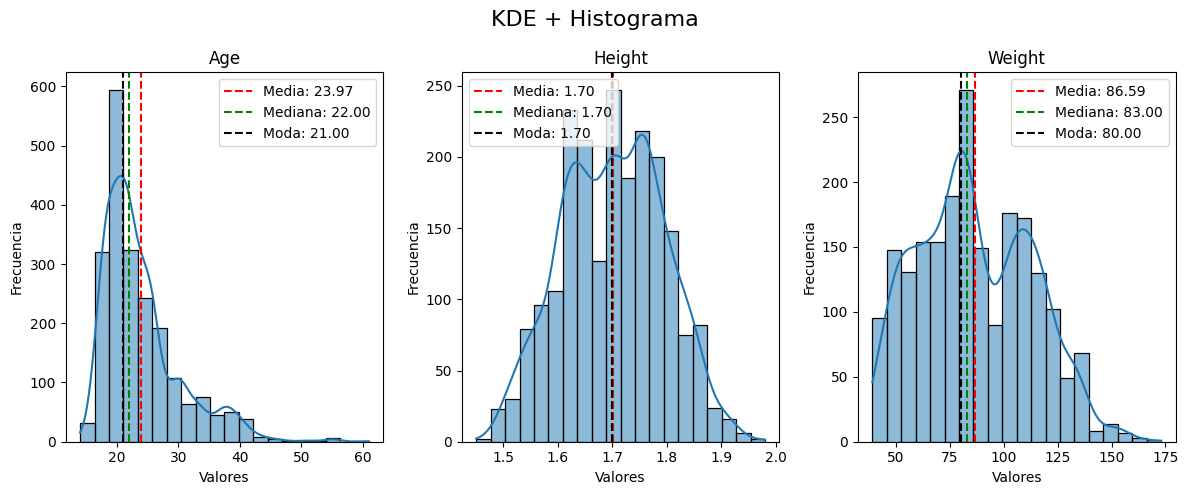

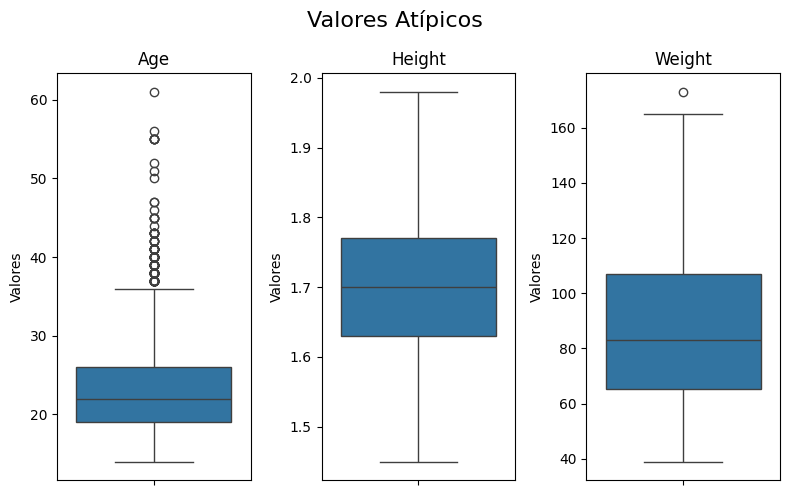

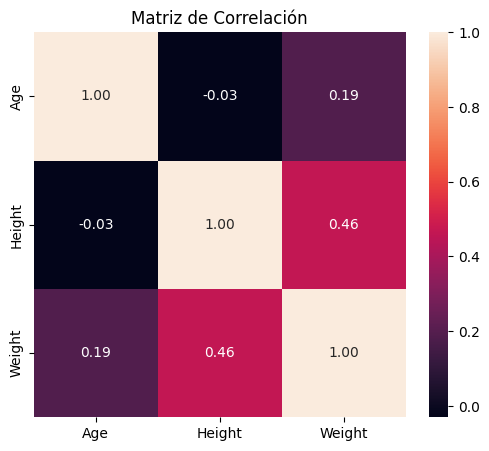

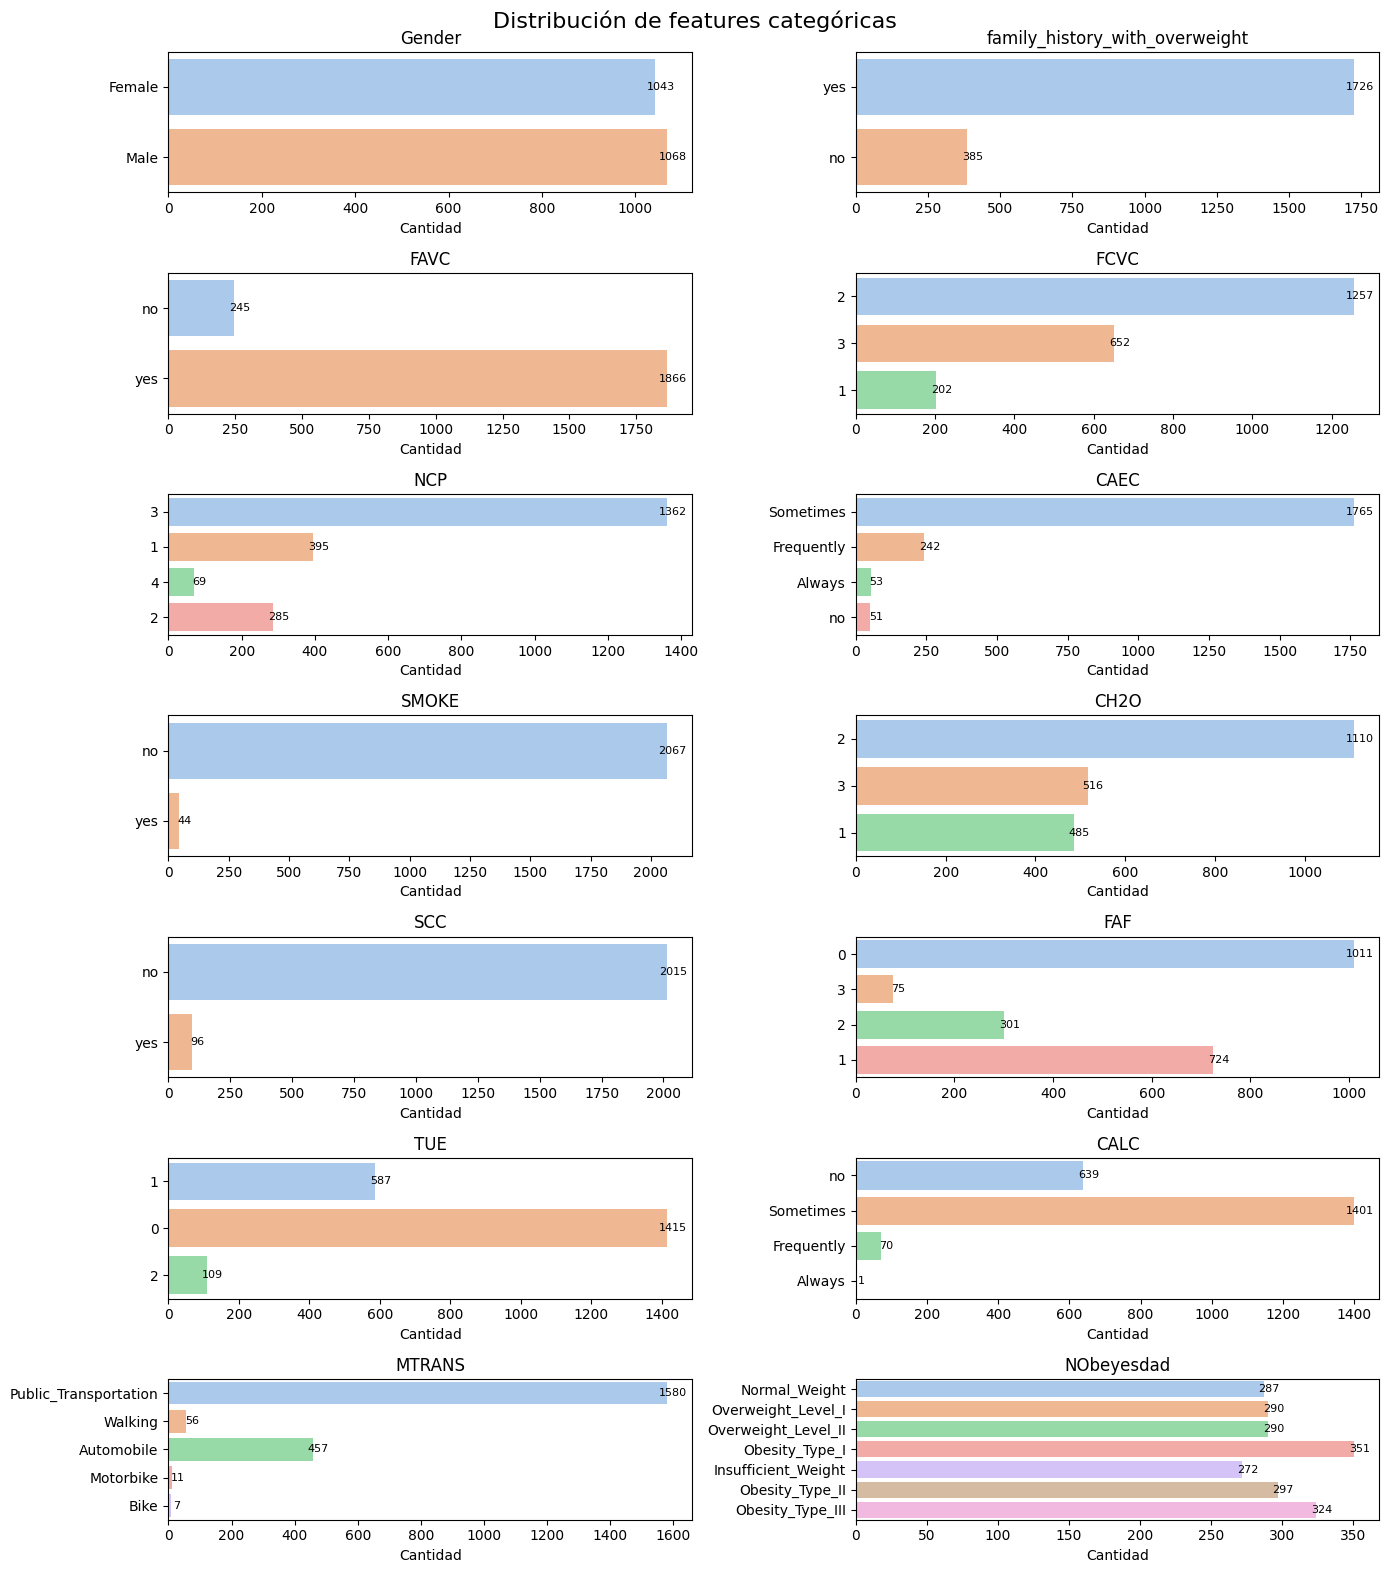

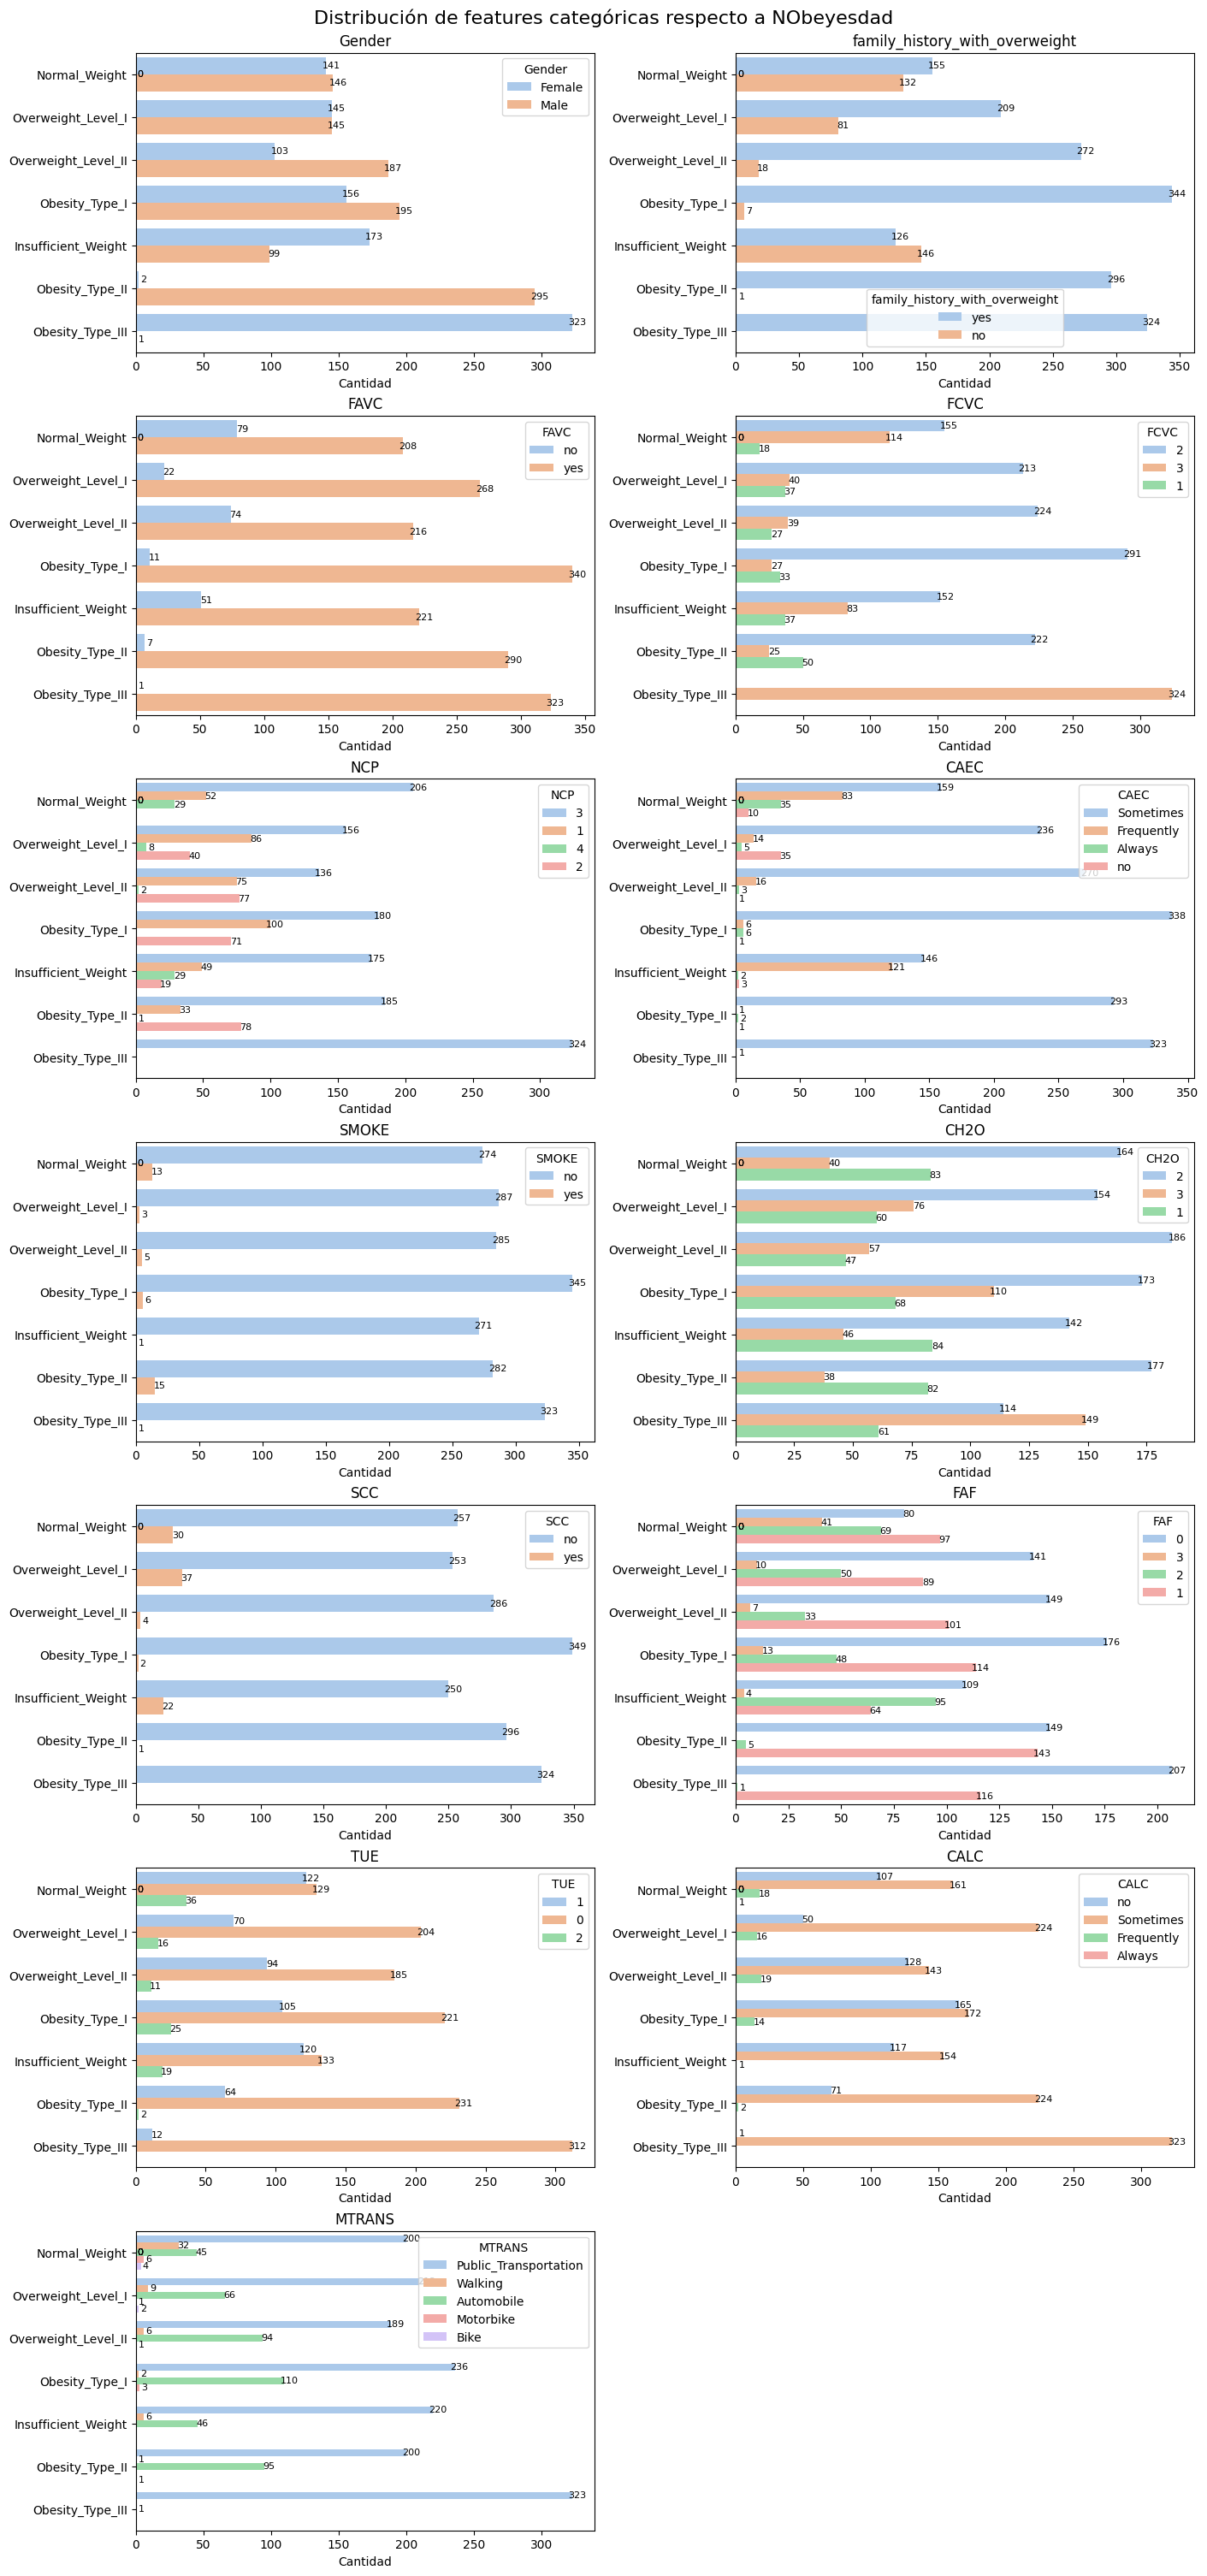

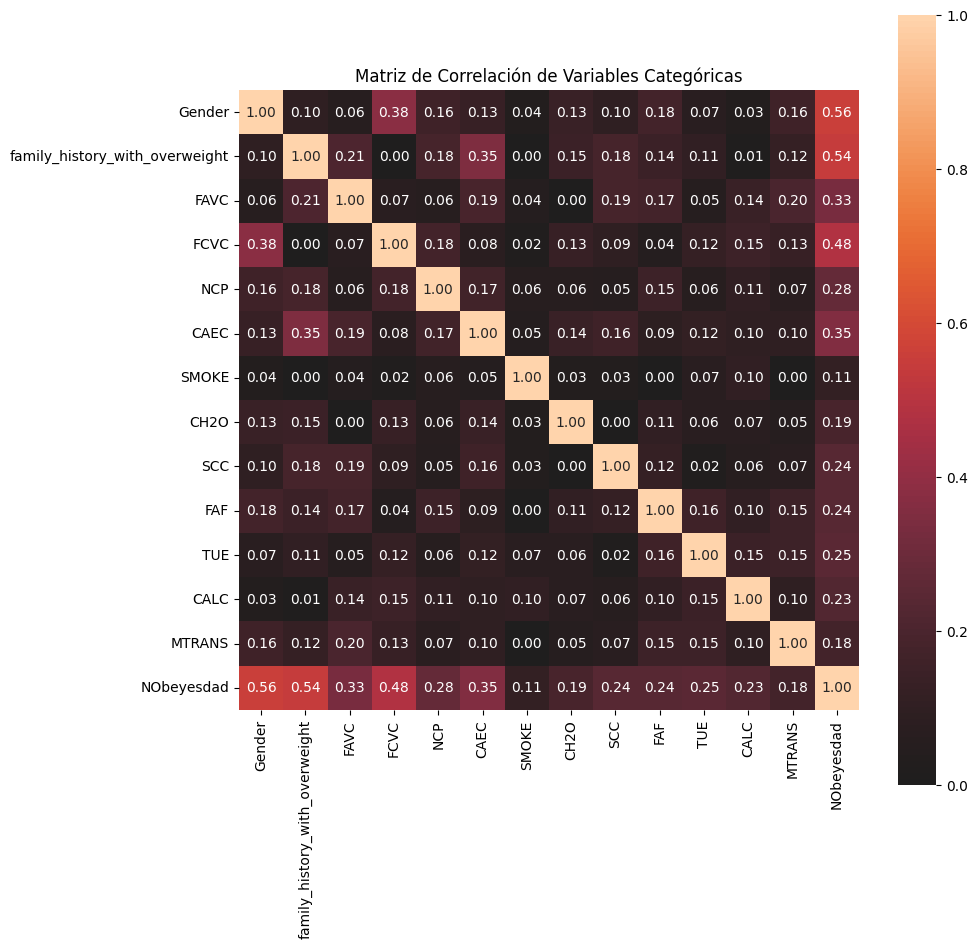

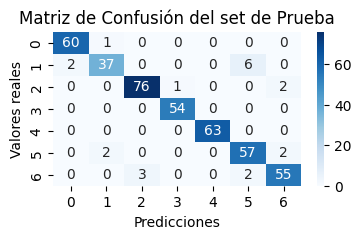

Classification Report del set de Prueba:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.98      0.98        61
      Normal_Weight       0.93      0.82      0.87        45
     Obesity_Type_I       0.96      0.96      0.96        79
    Obesity_Type_II       0.98      1.00      0.99        54
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.88      0.93      0.90        61
Overweight_Level_II       0.93      0.92      0.92        60

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



In [12]:
filepath = r'D:\MNA\MLOps\obesity\data\raw\ObesityDataSet_raw_and_data_sinthetic.csv'
main(filepath)
